In [10]:
import numpy as np
import pandas as pd
import re
import time
from datasketch import MinHash, MinHashLSHForest
import pickle
import pymongo

Δεδομένων όλων των ομιλιών, πρέπει να ανιχνεύσουμε ομοιότητες ανά ζεύγη μεταξύ των μελών του κοινοβουλίου. Συγκεκριμένα, πρέπει να βρούμε έναν τρόπο να εξαγάγουμε ένα διάνυσμα χαρακτηριστικών για κάθε μέλος και στη συνέχεια να εκτελέσουμε ομοιότητες ανά ζεύγη για να μπορέσουμε να ανιχνεύσουμε τα top-k ζεύγη με τον υψηλότερο βαθμό ομοιότητας (όπου k είναι μια παράμετρος).

In [11]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
#mongo_client.drop_database("GreekParliamentProceedings")
client = mongo_client["GreekParliamentProceedings"]
index = client["InvertedIndex"]
database = client["Database"]
print(type(database))

<class 'pymongo.collection.Collection'>


In [12]:
with open('results/member_keywords.pickle', 'rb') as handle:
    keywords_by_member = pickle.load(handle)
#print(list(keywords_by_member['τσιπρας παυλου αλεξιος'].keys()))
member_names = keywords_by_member.keys()
keywords = [list(keywords_by_member[member].keys()) for member in member_names]

### Διάνυσμα χαρακτηριστικών για κάθε μέλος

In [ ]:
#CREATE A VECTOR FOR EACH MEMBER IN A PANDAS DATAFRAME
member_names = keywords_by_member.keys()
keywords = [list(keywords_by_member[member].keys()) for member in member_names]
genders = []
political_parties = []
member_roles = []
regions = []
governments = []
def get_attributes_by_member(members, collection):
        for member in members:
                print(member)
                pipeline = [{'$match' : {'member_name':member}},
                            {'$facet': {
                                'groupByRoles':[{'$group':{'_id':'$roles'}}],
                                'groupByGender':[{'$group':{'_id':'$member_gender'}}],
                                'groupByGovernment':[{'$group':{'_id':'$government'}}],
                                'groupByParty':[{'$group':{'_id':'$political_party'}}],
                                'groupByRegion':[{'$group':{'_id':'$member_region'}}]
                            }
                                        }
                        ]
                r = list(collection.aggregate(pipeline))
                genders.append(r[0]['groupByGender'][0]['_id'])
                regions.append([r[0]['groupByRegion'][i]['_id'] for i in range(len(r[0]['groupByRegion']))])
                member_roles.append([r[0]['groupByRoles'][i]['_id'] for i in range(len(r[0]['groupByRoles']))])
                governments.append([r[0]['groupByGovernment'][i]['_id'] for i in range(len(r[0]['groupByGovernment']))])
                political_parties.append([r[0]['groupByParty'][i]['_id'] for i in range(len(r[0]['groupByParty']))])
                
        return genders, regions, political_parties, member_roles, governments

In [ ]:
genders, regions, political_parties, member_roles, governments = get_attributes_by_member(member_names, database)

In [ ]:
print(len(member_names))
print(len(keywords))
print(len(genders))
print(len(regions))
print(len(member_roles))
print(len(governments))
print(len(political_parties))

In [ ]:
#CREATE PANDAS DATAFRAME
data = {'Name': member_names,
        'Gender': genders,
        'Region(s)':regions,
        'Role(s)':member_roles,
        'Government(s)':governments,
        'Political party':political_parties,
        'Keywords':keywords}
df = pd.DataFrame(data)
df.head(4)

### Ομοιότητες ανά ζεύγη: MinHash + LSH

In [13]:
# FOLLOWED THE TUTORIAL FROM: https://www.pinecone.io/learn/locality-sensitive-hashing/
# STEP 1. CREATE K SHINGLES FOR EACH VECTOR
def get_k_shingles(vector: list, k: int):
    word = ' '.join(vector)
    shingles = []
    for i in range(len(word) - k+1):
        shingles.append(word[i:i+k])
    return set(shingles)

#all_shingles is a list of sets
def get_vocabulary(all_shingles:list):
    vocab = set()
    for i in range(len(all_shingles)):
        vocab.update(all_shingles[i])
        
    return vocab

In [52]:
all_shingles = []
for list_ in keywords:
    all_shingles.append(get_k_shingles(list_,4))
vocab = get_vocabulary(all_shingles)
print(len(vocab))

4804


In [53]:
hash_ = [i for i in range(0, len(vocab))]
#print(hash_)
from random import shuffle
hashes = []
for i in range(128):
    shuffle(hash_)
    hashes.append(list(hash_))
#shuffle(hash_)
#print(hash_)
#shuffle(hash_)
#print(hash_)

In [54]:
hashes[4].index(0)

873

In [56]:
#CREATE SPARSE MATRIX MxN, WHERE M = LEN(keywords) and N = LEN(vocab)
matrix = []
for keyword_list in keywords:
    matrix.append([0 for i in range(len(vocab))])
for i, shingle in enumerate(all_shingles):
    for s in shingle:
        position = list(vocab).index(s)
        matrix[i][position] = 1

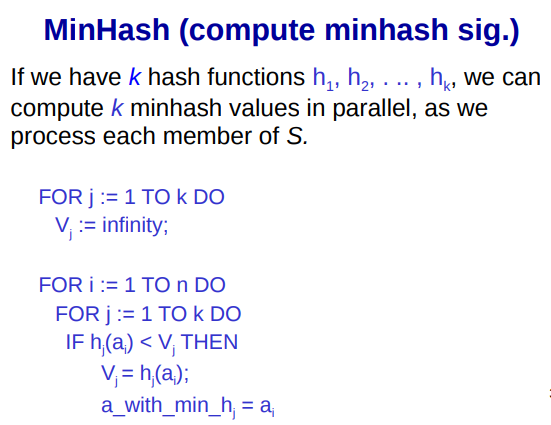

In [57]:
#INITIALISE SIGNATURE MATRIX
signature_matrix = []
for i in range(len(keywords)):
    signature_matrix.append([len(hashes)+10 for i in range(len(hashes))])
print(f'Signature matrix has {len(signature_matrix)} rows and {len(signature_matrix[1])} columns',)
print(f'Sparse matrix has {len(matrix)} rows and {len(matrix[0])} columns',)
print(f'There are {len(hashes)} hashes with {len(hashes[1])} values each',)


Signature matrix has 1523 rows and 128 columns
Sparse matrix has 1523 rows and 4804 columns
There are 128 hashes with 4804 values each


In [58]:
for i in range(len(matrix[0])):
    #print(f'Checking column {i+1}/{len(matrix[0])}')
    for j in range(len(matrix)):
        if(matrix[j][i]==1):
            # there are k=128 hashes, each hash has i=408 items
            for k, hash_ in enumerate(hashes):
                if(hash_[i]<signature_matrix[j][k]):
                    signature_matrix[j][k] = hash_[i]

In [63]:
print((signature_matrix[1]))
print((signature_matrix[2]))
bands = 16
rows = 8 


[92, 138, 92, 1, 37, 48, 68, 43, 31, 138, 36, 8, 138, 135, 138, 92, 104, 2, 78, 33, 36, 138, 122, 129, 76, 4, 81, 99, 61, 55, 138, 138, 138, 138, 78, 138, 54, 58, 116, 5, 138, 138, 138, 138, 102, 34, 93, 114, 138, 10, 138, 138, 82, 138, 138, 40, 89, 48, 138, 104, 138, 123, 12, 7, 72, 48, 138, 138, 138, 26, 138, 52, 110, 138, 24, 138, 9, 138, 137, 22, 123, 36, 5, 74, 45, 38, 94, 56, 138, 117, 26, 138, 138, 138, 82, 138, 95, 72, 116, 36, 77, 31, 46, 15, 35, 138, 26, 67, 124, 32, 121, 16, 103, 30, 138, 138, 88, 36, 54, 40, 17, 138, 31, 28, 50, 49, 103, 26]
[40, 117, 103, 97, 138, 138, 138, 138, 6, 59, 66, 138, 10, 5, 63, 1, 26, 41, 22, 92, 138, 138, 83, 5, 75, 138, 138, 138, 135, 138, 31, 138, 12, 138, 17, 136, 101, 61, 130, 138, 138, 138, 87, 138, 10, 113, 73, 138, 76, 5, 138, 8, 138, 54, 86, 138, 79, 81, 138, 138, 138, 138, 138, 138, 0, 138, 38, 1, 84, 120, 138, 22, 138, 138, 138, 43, 114, 126, 138, 138, 21, 75, 138, 48, 14, 138, 138, 3, 138, 138, 138, 25, 138, 39, 86, 138, 12, 87, 138,

### LSH

In [59]:
def jaccard_similarity(signature1: list, signature2: list):
    sig1 = set(signature1)
    sig2 = set(signature2)
    return len(sig1.intersection(sig2)) / len(sig1.union(sig2))

In [83]:
#SPLIT SIGNATURE MATRIX TO B SUBVECTORS WITH R ROWS EACH
def split(signature_matrix:list, b:int, rows:int):
    steps = [i for i in range(0,len(signature_matrix[0]),rows)]
    #print(steps)
    steps.append(len(signature_matrix[0]))
    splits = [signature_matrix[steps[i]:steps[i+1]] for i in range(len(steps)-1)]
    #for i in range(len(steps)-1):
        #print(steps[i], steps[i+1])
    return splits

bands = split(signature_matrix, 32, 4)
print(len(bands[15]))

4


In [89]:
for band in bands:
    print(len(band[1]))
    for i in range(len(band[0])):
        sig = []
        for j in range(len(band)):
            sig.append(band[j][i])
        #ToDo: hash signature to bucket
        #http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf

128
[138, 92, 40, 10]
[35, 138, 117, 138]
[77, 92, 103, 20]
[33, 1, 97, 110]
[37, 37, 138, 39]
[138, 48, 138, 30]
[41, 68, 138, 138]
[13, 43, 138, 138]
[92, 31, 6, 113]
[138, 138, 59, 22]
[27, 36, 66, 36]
[27, 8, 138, 23]
[138, 138, 10, 138]
[45, 135, 5, 138]
[30, 138, 63, 64]
[37, 92, 1, 92]
[1, 104, 26, 138]
[106, 2, 41, 41]
[10, 78, 22, 78]
[2, 33, 92, 33]
[41, 36, 138, 123]
[77, 138, 138, 138]
[138, 122, 83, 56]
[5, 129, 5, 78]
[76, 76, 75, 127]
[45, 4, 138, 4]
[81, 81, 138, 41]
[53, 99, 138, 60]
[138, 61, 135, 138]
[30, 55, 138, 109]
[88, 138, 31, 33]
[138, 138, 138, 138]
[58, 138, 12, 138]
[66, 138, 138, 53]
[138, 78, 17, 35]
[121, 138, 136, 41]
[54, 54, 101, 138]
[38, 58, 61, 58]
[46, 116, 130, 104]
[5, 5, 138, 35]
[138, 138, 138, 138]
[63, 138, 138, 138]
[138, 138, 87, 50]
[0, 138, 138, 138]
[17, 102, 10, 138]
[34, 34, 113, 138]
[93, 93, 73, 116]
[50, 114, 138, 37]
[22, 138, 76, 138]
[132, 10, 5, 96]
[30, 138, 138, 138]
[87, 138, 8, 25]
[36, 82, 138, 138]
[86, 138, 54, 25]
[86,